# Eventos de temperatura extrema em Porto Alegre

Neste exemplo vamos:

- Utilizar uma `API` pública para obter dados climáticos de Porto Alegre.

- Utilizar `pandas`, `numpy` e `scipy` para calcular a frequência de eventos de temperatura extrema.

- Utilizar `matplotlib` para fazer gráficos que nos ajudarão na análise dos dados.

A [Open-Meteo](https://open-meteo.com/) é uma `API` de código aberto sobre histórico e previsão de dados climáticos em qualquer localização do planeta. Vamos utilizá-la para obter a temperatura máxima por dia, nos últimos 20 anos, em Porto Alegre 

In [1]:
import requests

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": -30.0331,
    "longitude": -51.23,
    "start_date": "2004-01-01",
    "end_date": "2024-12-31",
    "daily": ["temperature_2m_max"],
    "timezone": "America/Sao_Paulo"
}

response = requests.get(url, params=params)

In [2]:
response.json()["daily"].keys()

dict_keys(['time', 'temperature_2m_max'])

In [3]:
import pandas as pd

df = pd.DataFrame(response.json()["daily"])
df["time"] = pd.to_datetime(df["time"])
df.rename(columns={"temperature_2m_max": "temp_max"}, inplace=True)
df

,time,temp_max
0,2004-01-01,21.9
1,2004-01-02,25.0
2,2004-01-03,27.1
3,2004-01-04,28.6
4,2004-01-05,30.7
...,...,...
7666,2024-12-27,27.8
7667,2024-12-28,26.1
7668,2024-12-29,26.3
7669,2024-12-30,27.4


In [4]:
df["month_day"] = df["time"].apply(lambda x: x.strftime("%m-%d"))
df

,time,temp_max,month_day
0,2004-01-01,21.9,01-01
1,2004-01-02,25.0,01-02
2,2004-01-03,27.1,01-03
3,2004-01-04,28.6,01-04
4,2004-01-05,30.7,01-05
...,...,...,...
7666,2024-12-27,27.8,12-27
7667,2024-12-28,26.1,12-28
7668,2024-12-29,26.3,12-29
7669,2024-12-30,27.4,12-30


In [5]:
from scipy.ndimage import gaussian_filter1d

temp_day = df.groupby("month_day")[["temp_max"]].mean()
temp_day.rename(columns={"temp_max": "mean"}, inplace=True)
temp_day["std"] = df.groupby("month_day")[["temp_max"]].std()

temp_day["mean_smooth"] = gaussian_filter1d(temp_day["mean"], sigma=5)

temp_day

,mean,std,mean_smooth
month_day,,,
01-01,29.842857,3.515618,29.516699
01-02,28.847619,3.809937,29.539840
01-03,28.490476,3.426063,29.583636
01-04,28.923810,2.644599,29.643364
01-05,29.461905,1.992354,29.712514
...,...,...,...
12-27,29.309524,3.539195,29.610150
12-28,29.761905,3.741186,29.671121
12-29,30.071429,3.171300,29.721100


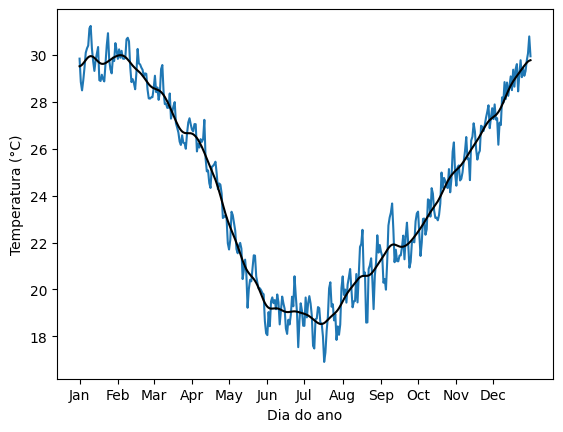

In [6]:
import matplotlib.pyplot as plt
import calendar

x_ticks = []
x_labels = []
for idx, month_day in enumerate(temp_day.index):
    month, day = [int(y)  for y in month_day.split("-")]
    if day == 1:
        x_ticks.append(idx)
        x_labels.append(calendar.month_abbr[month])

plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xlabel("Dia do ano")
plt.ylabel("Temperatura (°C)")

plt.plot(temp_day.index, temp_day["mean"])
plt.plot(temp_day.index, gaussian_filter1d(temp_day["mean"], sigma=5), c="black")

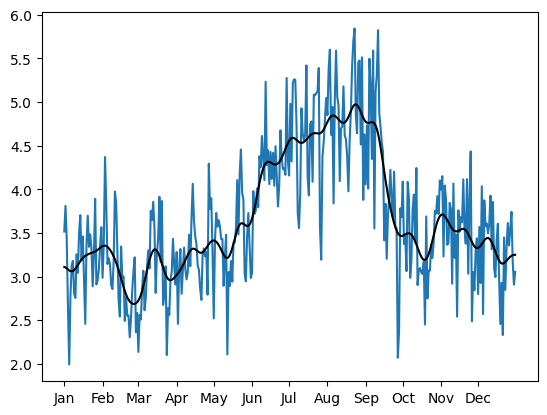

In [7]:
temp_day["std_smooth"] = gaussian_filter1d(temp_day["std"], sigma=5)

plt.xticks(ticks=x_ticks, labels=x_labels)

plt.plot(temp_day["std"])
plt.plot(temp_day["std_smooth"], c="black")

In [8]:
import numpy as np

def extreme_event(df: pd.DataFrame, temp_day: pd.DataFrame, n, k):
    all_mean = df["month_day"].map(temp_day["mean_smooth"])
    all_std = df["month_day"].map(temp_day["std_smooth"])

    above = df["temp_max"] > all_mean + k * all_std

    kernel = np.full(n, 1)

    return np.convolve(above, kernel)[n-1:] == n 

df["extreme"] = extreme_event(df, temp_day, n=4, k=1)

In [9]:
df["ano"] = df["time"].apply(lambda x: x.year)
extreme_year = df.groupby("ano")[["extreme"]].sum()
extreme_year

,extreme
ano,
2004,6
2005,14
2006,10
2007,13
2008,6
2009,13
2010,1
2011,0
2012,29


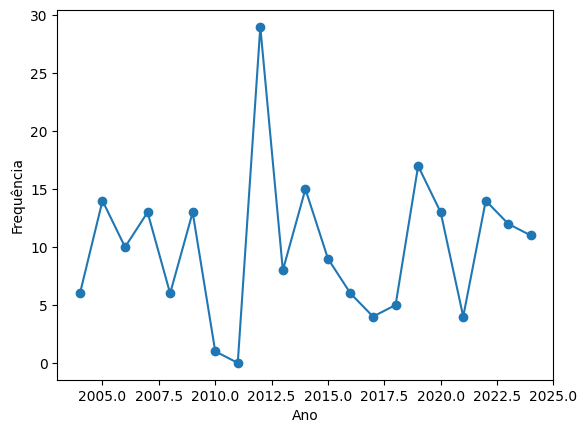

In [10]:
plt.xlabel("Ano")
plt.ylabel("Frequência")

plt.plot(extreme_year, "o-")

# Exercícios

1. Crie uma função que recebe um `DataFrame` com os dados de temperatura máxima em função do dia (os dados que obtemos usando a API da Open-Meteo), e um ano. A função deve fazer o gráfico da temperatura em função do tempo para o ano especificado, ou seja, uma função com a seguinte assinatura:
    ```python
    def max_temp_graph(max_temperature_df, year):
        # Código que faz o gráfico da temperatura em função do tempo para o ano `year`.
    ```

2. Identifique os 3 anos com maior ocorrência de eventos de temperatura extrema. Exiba esses anos e seus respectivos números de eventos extremos.

3. Calcule a média móvel da frequência dos eventos extremos em função dos anos. Dica: Olhe esta seção sobre _rolling window_: https://pandas.pydata.org/docs/user_guide/window.html#rolling-window

    Coloque no mesmo gráfico a ocorrência de eventos extremos em função dos anos e a média móvel calculada.

4. Calcule a frequência de eventos extremos de baixa temperatura ao longo dos anos. Considere como eventos extremos de baixa temperatura aqueles em que a temperatura está significativamente abaixo da média, seguindo a mesma lógica utilizada para os eventos extremos de alta temperatura, mas invertendo o critério. Para evitar confusão, segue uma definição formal destes eventos:

    ---

    Seja $T_y(t)$ a temperatura mínima no dia, em função do tempo no ano $y$, e $N$ o número total de anos. Sejam 
    
    $$
    \begin{aligned}
    \bar T(t) &= \frac{1}{N}\sum_y T_y(t) \to \text{Média de $T_y$ ao longo dos anos} \\
    \sigma_T^2(t) &= \frac{1}{N}\sum_y \bigg(T_y(t) - \bar T(t)\bigg)^2 \to \text{Variância de $T_y(t)$ ao longo dos anos.}
    \end{aligned}
    $$

    Dizemos que houve um evento de temperatura extrema em $t = t_{ext}$ no ano $y$ se

    $$
    T_y(t) < \bar T(t) - k \sigma_T(t), \text{para todo } t \in (t_{ext}, t_{ext} + \Delta t)
    $$

    em que $k$ e $\Delta t$ são parâmetros escolhidos pelo cientista de dados fazendo esta análise.
    
    ---

    No exemplo em aula apenas baixamos os dados de temperatura máxima por dia, mas baixar os dados de temperatura mínima por dia é bem simples. O código a seguir requisita os dados e salva eles em um arquivo .csv

    ```python
    import requests

    url = "https://archive-api.open-meteo.com/v1/archive"

    # Para obter a temperatura mínima em função do tempo,
    # apenas é necessário adicionar "temperature_2m_min" no campo "daily"
    params = {
        "latitude": -30.0331,
        "longitude": -51.23,
        "start_date": "2004-01-01",
        "end_date": "2024-12-31",
        "daily": ["temperature_2m_max", "temperature_2m_min"],
        "timezone": "America/Sao_Paulo"
    }
    response = requests.get(url, params=params)

    # Colocando os dados em um DataFrame e salvando o mesmo
    import pandas as pd
    df = pd.DataFrame(response.json()["daily"])
    df["time"] = pd.to_datetime(df["time"])
    df.rename(columns={"temperature_2m_max": "temp_max"}, inplace=True)
    df.rename(columns={"temperature_2m_min": "temp_min"}, inplace=True)
    df.to_csv("temp_mim_max.csv")
    ```

5. Coloque no mesmo gráfico a frequência de eventos extremos de alta e baixa temperatura em função dos anos. 

# Soluções

## Ex. 1

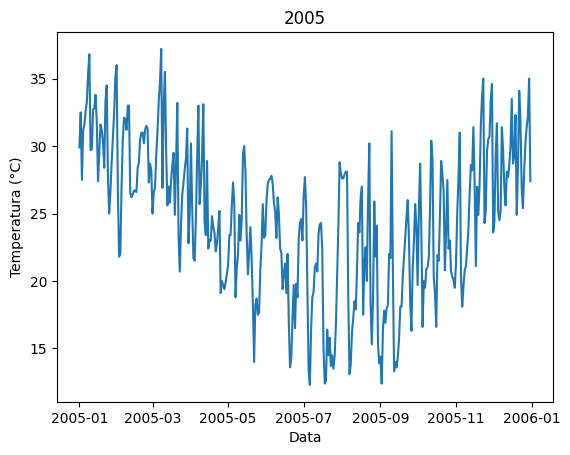

In [11]:
def max_temp_graph(max_temperature_df: pd.DataFrame, year):
    year_mask = max_temperature_df["time"].apply(
        lambda x: x.year == year
    )

    year_data = max_temperature_df.loc[year_mask, ["time", "temp_max"]]
    
    plt.title(year)
    plt.xlabel("Data")
    plt.ylabel("Temperatura (°C)")

    plt.plot(year_data["time"], year_data["temp_max"])

max_temp_graph(df, 2005)

## Ex. 2

In [12]:
extreme_year.sort_values("extreme", ascending=False)[:3]

,extreme
ano,
2012,29
2019,17
2014,15


Ex. 3

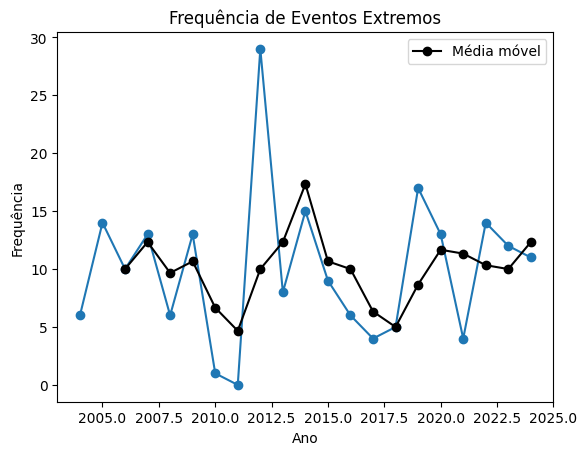

In [13]:
window = 3

moving_average = extreme_year.rolling(window=3).mean().dropna()

plt.title("Frequência de Eventos Extremos")
plt.xlabel("Ano")
plt.ylabel("Frequência")

plt.plot(extreme_year, "o-")
plt.plot(moving_average, "o-", c="black", label="Média móvel")

plt.legend()

## Ex. 4

In [14]:
import requests

url = "https://archive-api.open-meteo.com/v1/archive"

# Para obter a temperatura mínima em função do tempo,
# apenas é necessário adicionar "temperature_2m_min" no campo "daily"
params = {
    "latitude": -30.0331,
    "longitude": -51.23,
    "start_date": "2004-01-01",
    "end_date": "2024-12-31",
    "daily": ["temperature_2m_max", "temperature_2m_min"],
    "timezone": "America/Sao_Paulo"
}
response = requests.get(url, params=params)

# Colocando os dados em um DataFrame e salvando o mesmo
import pandas as pd
df2 = pd.DataFrame(response.json()["daily"])
df2["time"] = pd.to_datetime(df2["time"])
df2.rename(columns={"temperature_2m_max": "temp_max"}, inplace=True)
df2.rename(columns={"temperature_2m_min": "temp_min"}, inplace=True)

df2

,time,temp_max,temp_min
0,2004-01-01,21.9,16.3
1,2004-01-02,25.0,13.8
2,2004-01-03,27.1,14.1
3,2004-01-04,28.6,17.2
4,2004-01-05,30.7,17.7
...,...,...,...
7666,2024-12-27,27.8,17.8
7667,2024-12-28,26.1,18.8
7668,2024-12-29,26.3,18.7
7669,2024-12-30,27.4,18.3


In [15]:
from scipy.ndimage import gaussian_filter1d

df2["month_day"] = df2["time"].apply(lambda x: x.strftime("%m-%d"))

temp_min_day = df2.groupby("month_day")[["temp_min"]].mean()
temp_min_day.rename(columns={"temp_min": "mean"}, inplace=True)
temp_min_day["std"] = df2.groupby("month_day")[["temp_min"]].std()

temp_min_day["mean_smooth"] = gaussian_filter1d(temp_min_day["mean"], sigma=5)
temp_min_day["std_smooth"] = gaussian_filter1d(temp_min_day["std"], sigma=5)

temp_min_day

,mean,std,mean_smooth,std_smooth
month_day,,,,
01-01,20.871429,2.146659,20.638402,2.312464
01-02,20.680952,2.512891,20.652483,2.301160
01-03,20.009524,2.847614,20.679716,2.279498
01-04,20.371429,2.539319,20.718207,2.249304
01-05,20.119048,2.425617,20.765097,2.213137
...,...,...,...,...
12-27,19.747619,2.395541,20.226989,2.218107
12-28,20.166667,2.289833,20.278812,2.225435
12-29,20.633333,2.008565,20.321176,2.230607


In [16]:
import numpy as np

def extreme_event_min(df: pd.DataFrame, temp_day: pd.DataFrame, n, k):
    all_mean = df["month_day"].map(temp_day["mean_smooth"])
    all_std = df["month_day"].map(temp_day["std_smooth"])

    above = df["temp_min"] < (all_mean - k * all_std)

    kernel = np.full(n, 1)

    return np.convolve(above, kernel)[n-1:] == n 

df2["extreme"] = extreme_event_min(df2, temp_min_day, n=4, k=1)

df2["ano"] = df2["time"].apply(lambda x: x.year)
extreme_min_year = df2.groupby("ano")[["extreme"]].sum()
extreme_min_year

,extreme
ano,
2004,13
2005,1
2006,12
2007,12
2008,15
2009,11
2010,12
2011,11
2012,9


## Ex. 5

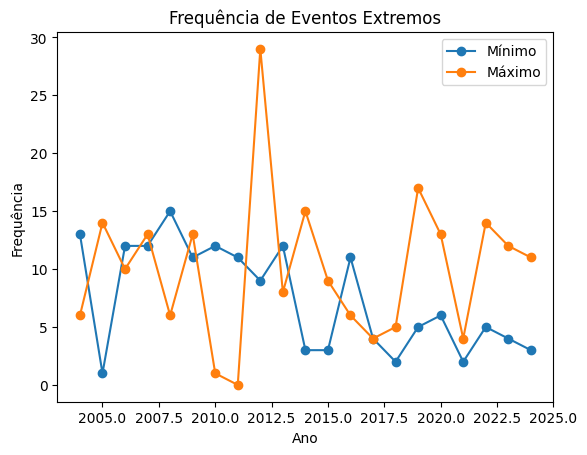

In [17]:
plt.title("Frequência de Eventos Extremos")
plt.xlabel("Ano")
plt.ylabel("Frequência")

plt.plot(extreme_min_year, "o-", label="Mínimo")
plt.plot(extreme_year, "o-", label="Máximo")

plt.legend()